Repo to app: https://github.com/Kerman18/streamlit_app.git

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import time
import matplotlib.pyplot as plt # for making figures
#import scienceplots
#plt.style.use(['science','notebook','grid']) # To make plot looks better

import re
import spacy
from collections import Counter
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Functions to clean and tokenize text data

In [3]:
### Text cleaning function
def clean_text(text):
    text=text.lower()
    text = re.sub(r"(?<=\w)'(?=\w)", "", text) # Remove apostrophes in contractions
    text = re.sub(r"[^a-zA-Z0-9\.]", " ", text) # Keep only alphanumeric characters and periods
    text = re.sub(r"\s+", " ", text) # Replace multiple spaces with a single space
    
    return text

nlp = spacy.load("en_core_web_sm") # Load the small English model

### Custom tokenization function
def custom_tokenize(texts):
    doc = nlp(texts)
    all_sentences_tokens = []

    for sent in doc.sents:
        tokens = []
        for i, token in enumerate(sent):
            if token.is_space:
                continue
            word = token.text
            tokens.append(" " + word)

        all_sentences_tokens.append(tokens)
    return all_sentences_tokens

Function to make training and validation data sets

In [4]:
### Making dataset
def make_dataset(tokenized_sentences, block_size,word2idx, idx2word,test_size):
    X, Y = [], []
    for sen in tokenized_sentences:
        context = [0] * block_size
        for w in sen:
    
          ix = word2idx[w]
          X.append(context)
          Y.append(ix)
          #print(''.join(idx2word[i] for i in context), '--->', idx2word[ix])
          context = context[1:] + [ix] # crop and append
  
    # Move data to device
    X = torch.tensor(X).to(device)
    Y = torch.tensor(Y).to(device)
    print("Total samples:", X.shape[0])
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=test_size, random_state=42,shuffle=True)

    return X_train, Y_train, X_val, Y_val

Function to plot embeddings

In [5]:
def plot_embeddings(emb,word2idx,idx2word,words=None,color='g'):
    fig,ax=plt.subplots(figsize=(10,8))
    weights = emb.weight.detach().cpu().numpy()
    tsne=TSNE(n_components=2,random_state=42)
    weight_2d=tsne.fit_transform(weights)
    
    x = weight_2d[:, 0]
    y = weight_2d[:, 1]
    
    ax.scatter(x, y, color='b',alpha=0.1)
    if words is not None:
        for i in words:
            idx= word2idx.get(i,word2idx["<unk>"])
            a,b=weight_2d[idx]
            ax.scatter(a, b, color=color)
            if idx is not None:
                ax.text(a+0.05, b+0.05, idx2word[idx]) 

    ax.set_title(f'Embedding Visualization')

Creating Nuaral Network with forward pass

In [6]:
class NextTokenPredictor(nn.Module):
    def __init__(self, vocab_size, embed_size, context_size, hidden_size):
        torch.manual_seed(42)
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_size,padding_idx=0)
        self.fc1 = nn.Linear(embed_size * context_size, hidden_size) # first fully connected layer
        #self.fc2=nn.Linear(hidden_size,hidden_size) #second fully connected layer
        self.fc3 = nn.Linear(hidden_size, vocab_size) # output layer
    
    def forward(self, x,act_fun='relu'):
        act = torch.tanh if act_fun == 'tanh' else F.relu
        x = self.emb(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = act(self.fc1(x))
        #x = act(self.fc2(x))
        x = self.fc3(x)
        return x

Function to summarize model

In [7]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def print_model_summary(model):
    print("Model Summary:")
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:
            params = sum(p.numel() for p in module.parameters())
            print(f"{name:<20} {params:,} parameters")
    print(f"\nTotal trainable parameters: {count_params(model):,}\n")

Function to train model

In [8]:
def train_model(model, X, Y, X_val,Y_val,epochs=250, batch_size=1024, lr=1e-3, print_every=50,act_fun='relu'):
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0) #ignore padding index

    losses, times,loss_val = [], [], []
    start = time.time()
    print('Training starts....')
    for epoch in range(epochs):
        total_loss, n_batches = 0, 0

        for i in range(0, X.shape[0], batch_size):
            x_batch = X[i:i+batch_size]
            y_batch = Y[i:i+batch_size]

            logits = model(x_batch,act_fun)
            loss = loss_fn(logits, y_batch)
            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()
            n_batches += 1
        
        # evaluating loss on validation set
        model.eval()
        val_loss_total,val_batch = 0,0
        with torch.no_grad():
            for i in range(0, len(X_val), batch_size):
                x_batch = X_val[i:i+batch_size]
                y_batch = Y_val[i:i+batch_size]
                logits = model(x_batch,act_fun)
                loss = loss_fn(logits, y_batch)
                val_loss_total += loss.item()
                val_batch +=1
        model.train()
        val_loss = val_loss_total / val_batch
        avg_loss = total_loss / n_batches
        
        loss_val.append(val_loss)
        losses.append(avg_loss)
        times.append(time.time() - start)
        
        if epoch % print_every == 0:
            print(f"Epoch {epoch:4d} | Loss: {avg_loss:.4f}, Val_Loss:{loss_val[-1]:.4f} | Time: {times[-1]:.2f}s")
    
    model.eval()
    with torch.no_grad():
        logits = model(X,act_fun)
        prob=F.softmax(logits,dim=1)
        #prob[:, 0] = 0  # remove pad contribution
        prob = prob.cpu().numpy()
        prob=np.mean(prob,axis=0)
    model.train()

    print(f'Final loss: {losses[-1]:.4f}|Final Val_loss:{loss_val[-1]:.4f}| Total Time: {times[-1]:.2f}s')

    plt.plot(np.arange(1,len(losses)+1), losses, label='Training Loss')
    plt.plot(np.arange(1,len(loss_val)+1), loss_val, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')
    plt.grid()

    return losses, loss_val,prob

Function to generate sentences from trained model

In [9]:
def generate_sentence(model, idx2word, block_size,act_fun ,max_len=10,seed=42):
    torch.manual_seed(seed)
    model.eval()
    with torch.no_grad():
        context = [0] * block_size
        sentence = ''
        for i in range(max_len):
            x = torch.tensor(context).view(1, -1).to(device)
            y_pred = model(x,act_fun)
            ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
            word = idx2word[ix]
            if word in ['<unk>', '*']:
                continue
            if word == ' .':
                sentence += word
                break
            sentence += word
            context = context[1:] + [ix]
    # Set model back to training mode
    model.train()
    return print(sentence)

Function to create vocabulary and mappings

In [10]:
def vocabulary(tokenized_sentences):
    all_words = [word for sentence in tokenized_sentences for word in sentence]
    counter = Counter(all_words)

    most_common10=[word for word, _ in counter.most_common(10)] # Get 10 most common words
    least_common10=[w for w,_ in counter.most_common()[-10:] ]# Get 10 least common words
    
    vocab = list(set(all_words))

    word2idx = {word: idx+2 for idx, word in enumerate(vocab)} # words to index mapping
    word2idx["<pad>"] = 0  # Padding token
    word2idx["<unk>"] = 1  # Unknown token
    idx2word = {idx: word for word, idx in word2idx.items()} # index to words mapping

    vocab_size = len(word2idx) # Vocabulary size including padding token

    print("10 Most common words with counts:", most_common10)
    print("10 Least common words with  counts:", least_common10)

    return vocab,vocab_size, word2idx, idx2word

Loading text data and tokenizing it

In [11]:
with open("/kaggle/input/sherlock-homes/1661-0.txt",encoding="utf-8") as f:
    raw = f.read()

text = clean_text(raw)
tokenized_sentences = custom_tokenize(text)
#print(tokenized_sentences)
random.shuffle(tokenized_sentences) # Shuffle the sentences
#print(tokenized_sentences)

In [12]:
vocab,vocab_size, word2idx, idx2word=vocabulary(tokenized_sentences)
print(f'Vocabulary Size: {vocab_size-2}') # Excluding padding and unknown tokens

10 Most common words with counts: [' .', ' the', ' and', ' i', ' to', ' of', ' a', ' in', ' that', ' it']
10 Least common words with  counts: [' sinned', ' martyrdom', ' atone', ' squalid', ' transform', ' restive', ' weighing', ' chapter', ' vacant', ' faintly']
Vocabulary Size: 8185


In [13]:
block_size = 5
emb_size = 32
func = 'relu'

In [14]:
X_train,Y_train,X_val,Y_val=make_dataset(tokenized_sentences, block_size, word2idx, idx2word,test_size=0.1)
X_train.shape,Y_train.shape,X_val.shape,Y_val.shape

Total samples: 115362


(torch.Size([103825, 5]),
 torch.Size([103825]),
 torch.Size([11537, 5]),
 torch.Size([11537]))

Model Summary:
emb                  261,984 parameters
fc1                  164,864 parameters
fc3                  8,391,675 parameters

Total trainable parameters: 8,818,523



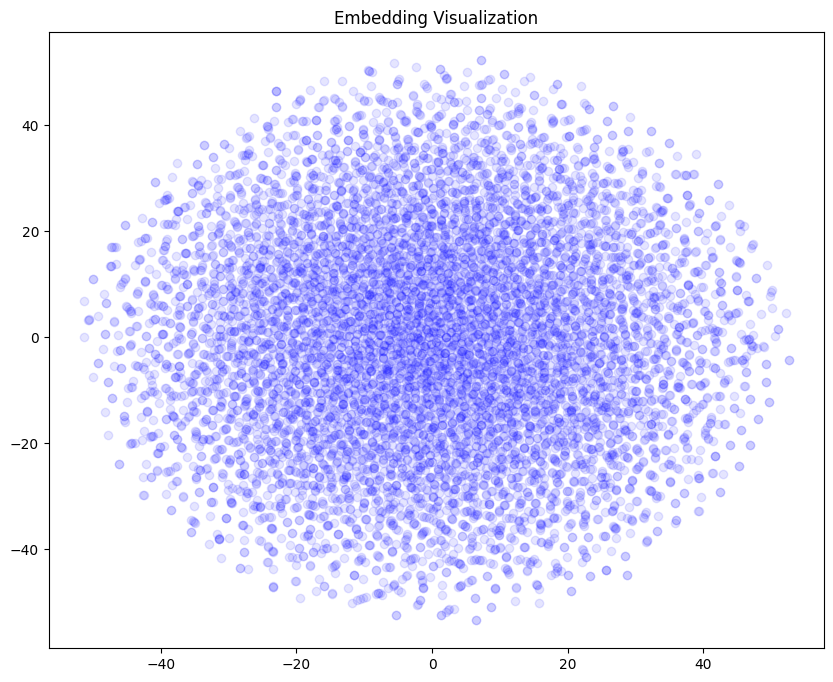

In [15]:
model= NextTokenPredictor(vocab_size, emb_size, block_size,hidden_size=1024).to(device)
print_model_summary(model)
plot_embeddings(model.emb,word2idx,idx2word)

Training starts....
Epoch    0 | Loss: 6.2357, Val_Loss:5.7337 | Time: 2.31s
Epoch   10 | Loss: 1.3597, Val_Loss:11.6084 | Time: 19.06s
Epoch   20 | Loss: 0.7471, Val_Loss:14.9332 | Time: 36.26s
Epoch   30 | Loss: 0.7388, Val_Loss:16.9998 | Time: 53.85s
Final loss: 0.6536|Final Val_loss:17.0725| Total Time: 70.04s


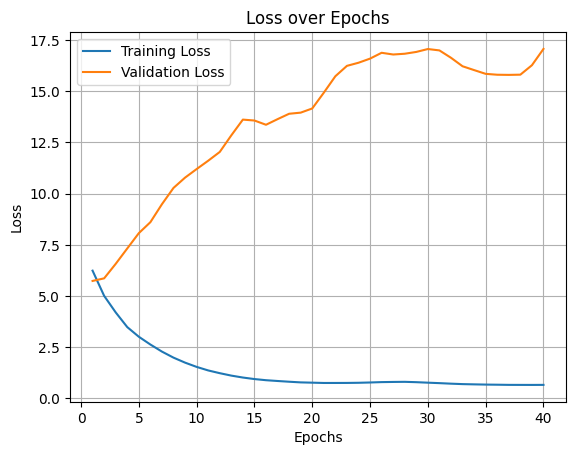

In [16]:
losses, val_loss,prob = train_model(model, X_train, Y_train,X_val,Y_val,epochs=40, batch_size=1024,lr=0.01, print_every=10,act_fun=func)

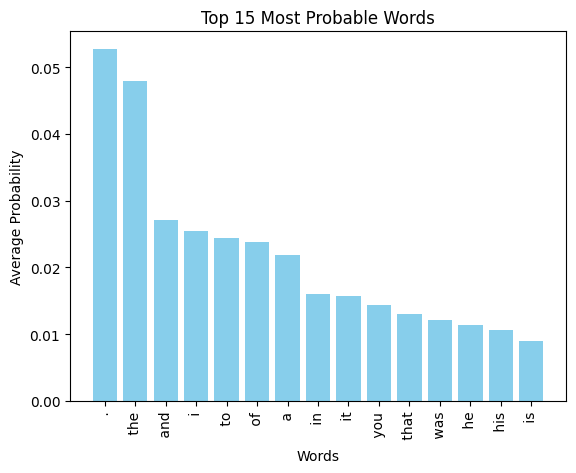

In [17]:
#prob.sum() # should be close to 1
top_indices = np.argsort(prob)[-15:][::-1]   # indices of 15 highest probs
top_probs = prob[top_indices]
top_words = [idx2word[i] for i in top_indices]

# Plot
plt.bar(top_words, top_probs, color='skyblue')
plt.xlabel("Words")
plt.ylabel("Average Probability")
plt.title("Top 15 Most Probable Words")
plt.xticks(rotation=90)
plt.show()

In [18]:
for i in range (10):
    seed=np.random.randint(0,200)
    generate_sentence(model, idx2word,block_size,func ,max_len=10,seed=seed)

 the name was strange to absolute .
 then it lengthened out of some very well know light
 you are fatigued with your haste said he .
 alas replied of is some sort or be plaid upon
 what he roared .
 it may seem that we like his wife in silence
 the letter which this hold its first .
 you have heard me remark that the strangest of many
 holmes gazed long and earnestly at it .
 she was forward and her father was far from home


## Comment in learning behaviour
As can be seen from above examples that sentences generated through this trained model are not perfect, but not too bad either. It has learned to put pronouns/names first followed by something like is, are, was or verb. Also, it learned to keep sentence with correct tenes.

In [19]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'word2idx': word2idx,
    'idx2word': idx2word,
    'embed_dim': emb_size,
    'hidden_dim': 1024,
    'activation': func,
    'context_length': block_size
}
torch.save(checkpoint, '/kaggle/working/model_cont10_emb32_relu.pt')

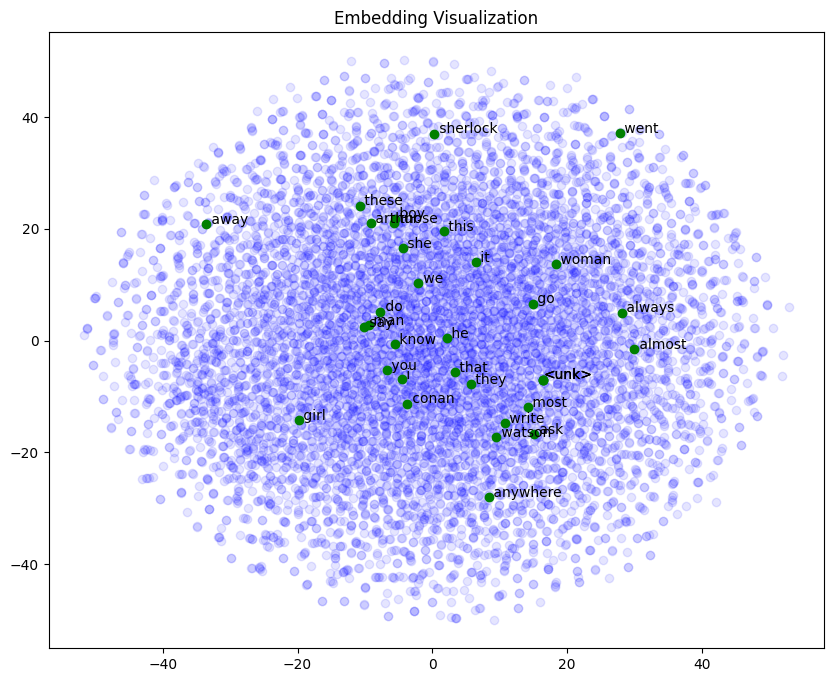

In [20]:
words=[' i', ' you', ' they',' he',' she',' it',' we' #pronouns
       ,' sherlock',' homes',' watson', ' arthur', ' conan' #names
       ,' this',' that',' these', ' those', ' man', ' woman', ' boy', ' girl' #  antonyms
       ,' anywhere', ' almost', ' whtasoever', ' away',' most',' always' #adverbs
       ,' go',' went', ' ask',' say',' write',' do', ' dont', ' know'  #verbs
      ]
plot_embeddings(model.emb,word2idx ,idx2word,words,color='green')

Embeding shows that antonyms are far away from each other. Also, some verbs (do,say, know) and some pronounes (you,i,he,they & he,it,we) are close together. But some embedings are not clear, as some name are close to pronouns (like conan), while some are close to verbs (watson) and some are far away from any cluster (sherlock).

# Structured Text

In [21]:
def prepare_latex_sentences(text):
    # Remove LaTeX comments
    text = re.sub(r'%.*', '', text)
    # Split by newlines
    lines=text.split('\n')

    #Keep non-empty lines and append \n to each line
    sentences = [line +'\n' for line in lines if line.strip()]
    return sentences

def tokenize_latex(sentence):
    TOKEN_REGEX = re.compile(r"""(\\[a-zA-Z]+)|([a-zA-Z_][a-zA-Z0-9_]*)|(\d+\.\d*|\.\d+|\d+)|(\S)""", re.VERBOSE)
    word=[w.group(0) for w in TOKEN_REGEX.finditer(sentence)]

    return word

In [22]:
with open("/kaggle/input/latex-code/algebraization.txt", "r", encoding="utf-8") as f:
    stru_text = f.read()
sentences = prepare_latex_sentences(stru_text)
tokenized = [tokenize_latex(s) for s in sentences]

In [23]:
vocab_latex,vocab_size_latex, word2idx_latex, idx2word_latex=vocabulary(tokenized)
print(f'Vocabulary Size (LaTeX): {vocab_size_latex-2}') # Excluding padding and unknown tokens

10 Most common words with counts: ['$', '{', '}', '(', ')', '-', ',', '\\mathcal', '.', '^']
10 Least common words with  counts: ['manipulations', 'S_3', 'Of', 'Varieties', 'varieties', 'chapters', '\\bibliography', 'my', '\\bibliographystyle', 'amsalpha']
Vocabulary Size (LaTeX): 2010


In [24]:
block_size_latex = 5
emb_size = 32
func = 'relu'

In [25]:
Xlatex_train,Ylatex_train,Xlatex_val,Ylatex_val=make_dataset(tokenized, block_size_latex, word2idx_latex, idx2word_latex,test_size=0.1)
Xlatex_train.shape,Ylatex_train.shape,Xlatex_val.shape,Ylatex_val.shape

Total samples: 118411


(torch.Size([106569, 5]),
 torch.Size([106569]),
 torch.Size([11842, 5]),
 torch.Size([11842]))

Model Summary:
emb                  64,384 parameters
fc1                  164,864 parameters
fc3                  2,062,300 parameters

Total trainable parameters: 2,291,548



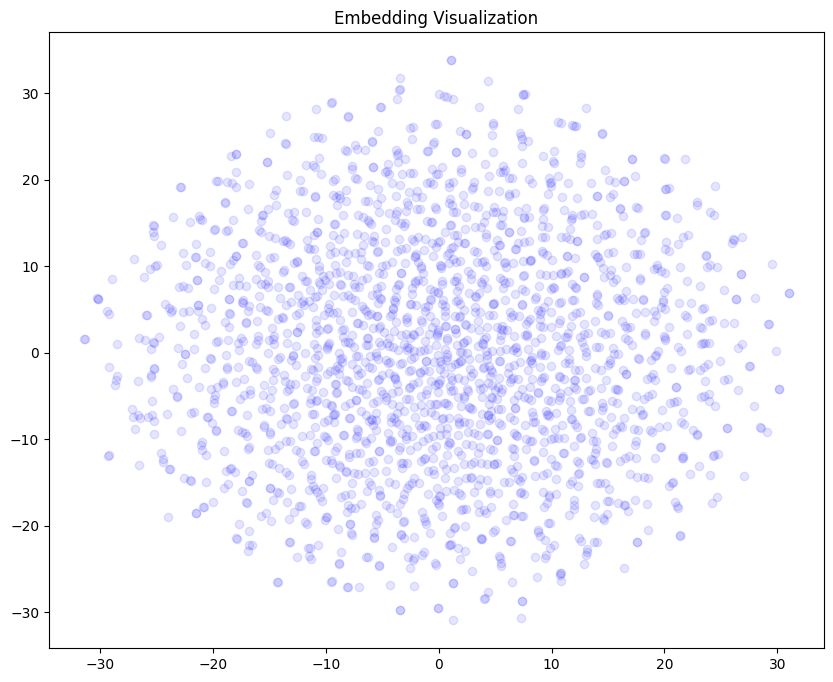

In [39]:
model_latex= NextTokenPredictor(vocab_size_latex, emb_size,block_size_latex,hidden_size=1024).to(device)
print_model_summary(model_latex)
plot_embeddings(model_latex.emb,word2idx_latex,idx2word_latex)

Training starts....
Epoch    0 | Loss: 2.9679, Val_Loss:2.3174 | Time: 0.62s
Epoch   10 | Loss: 1.0532, Val_Loss:2.8897 | Time: 6.30s
Final loss: 0.9480|Final Val_loss:2.8907| Total Time: 11.46s


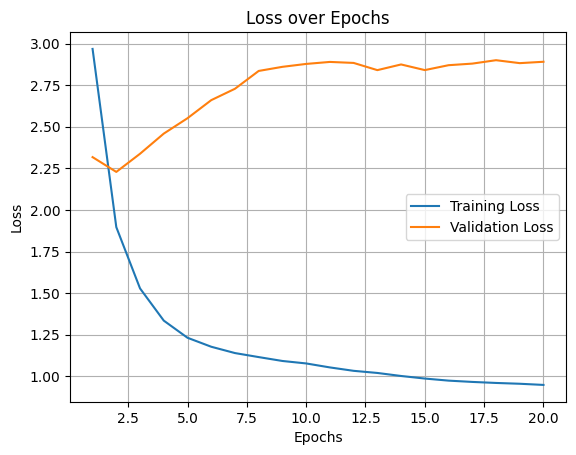

In [40]:
loss_latex,val_loss_latex,pred_latex=train_model(model_latex, Xlatex_train, Ylatex_train,Xlatex_val,Ylatex_val,epochs=20, batch_size=1024,lr=0.01,print_every=10,act_fun=func)

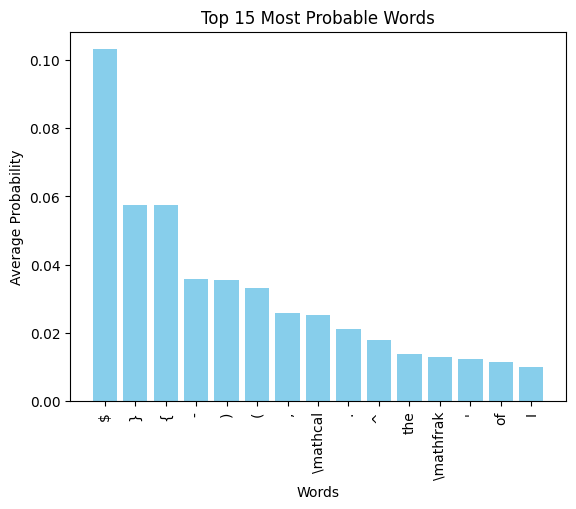

In [41]:
#prob_latex.sum() # should be close to 1
top_indices = np.argsort(pred_latex)[-15:][::-1]   # indices of 15 highest probs
top_probs = pred_latex[top_indices]
top_words = [idx2word_latex[i] for i in top_indices]

# Plot
plt.bar(top_words, top_probs, color='skyblue')
plt.xlabel("Words")
plt.ylabel("Average Probability")
plt.title("Top 15 Most Probable Words")
plt.xticks(rotation=90)
plt.show()

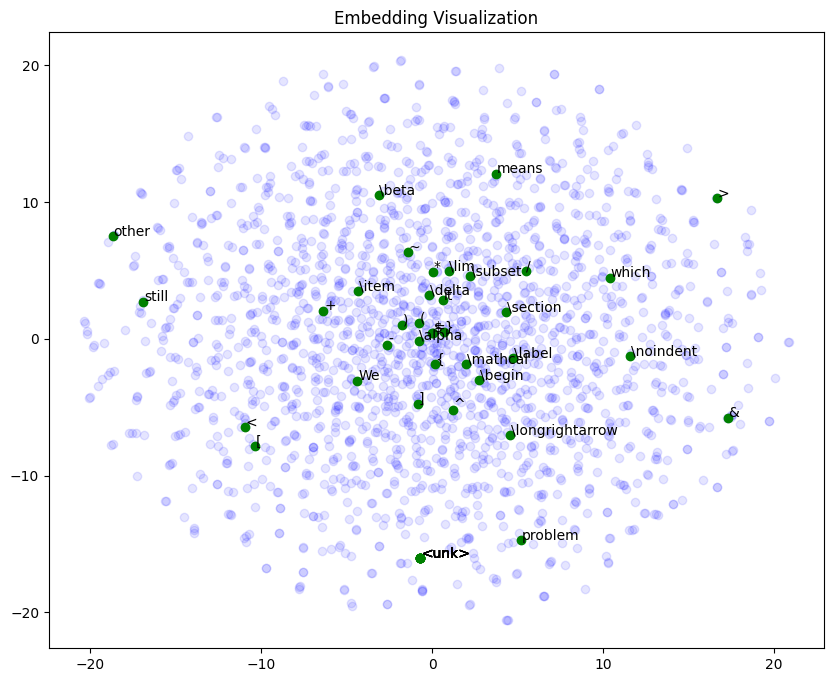

In [42]:
words=['\\alpha','\\beta','\\delta','\\longrightarrow','\\subset','\\lim' # symbols 
    ,'=','<=','>=','<','>','+','-','^','*','~','/','$','&' # numetic operations/comparision
    ,'{','}','(',')','[',']' #brakets
    ,'\\item','\ref','\\noindent','\\mathcal','\\label','\\section','\\subsection','\\begin','\\documentclass','\\end' # Latex comands
    'The','We','still','it','which','problem','law','means','leads','other' # english wods
    ]
plot_embeddings(model_latex.emb,word2idx_latex,idx2word_latex,words)

Here, two of the three type of brakets {} & () are close while the other [] are quite far as well as both side of braket are far from eachother as well. Numerical operatios (+,-,*) are relatively close but not too much, but comparison operation(> <) are away from each other which is what we expect. The english words are mostly on the outer parts, while latext command being close, showing model atleast understand the difference between latex code and normal language.

In [51]:
def generate_from_prompt(model, word2idx, idx2word, prompt, block_size, max_len,act_func):
    model.eval()

    # Tokenize prompt
    tokens = tokenize_latex(prompt)

    # Convert tokens to indices (handle unknowns)
    unk_idx = word2idx["<unk>"]
    pad_idx = word2idx["<pad>"]
    context = [word2idx.get(t, unk_idx) for t in tokens][-block_size:]

    # Pad if shorter than block_size
    if len(context) < block_size:
        context = [pad_idx] * (block_size - len(context)) + context

    generated = tokens.copy()

    with torch.no_grad():
        for _ in range(max_len):
            x = torch.tensor(context, dtype=torch.long, device=device).unsqueeze(0)
            logits = model(x,act_func)

            # Sample next token
            probs = F.softmax(logits, dim=1)
            probs[0,unk_idx]=0
            probs[0,pad_idx]=0
            
            sample_pos = torch.multinomial(probs, num_samples=1).item()
            word = idx2word[sample_pos]
            
            if word in ['<unk>', '<pad>']:
                continue

            generated.append(word)
            context = context[1:] + [sample_pos]

    model.train()
    return " ".join(generated)


In [55]:
text='\\begin{'
generate_from_prompt(model_latex,word2idx_latex,idx2word_latex,text,block_size_latex,max_len=10,act_func=func)

'\\begin { proof } [ T_1 , \\ldots , T_r ] \\to'

The text generated from the model are not much meaningful, but it some what learn to close the brakets properly. But it is not always true, it some time does not close the brakets or close it with wring one. So, even though the validation loss in the structured text are lower compared to natual language, the text generation through it is not very meaningful because this type of texts has to have well followed structure.